# Import functions and set TF_USE_LEGACY_KERAS = 1

In [13]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import sys
sys.path.insert(1,"../")
from data import write_data, gen_fcst_norm 
import numpy as np
from config import get_data_paths

data_paths = get_data_paths()
CONSTANTS_PATH = data_paths["GENERAL"]["CONSTANTS_PATH"]
FCSTNorm_year = "2018"


# Generate Forecast Normalisation constants if not created

In [ ]:
##Mean, STD, min, max
if not os.path.exists(CONSTANTS_PATH+f"FCSTNorm{FCSTNorm_year}.pkl"):
    gen_fcst_norm(year=FCSTNorm_year)

# For train years call write data

In [ ]:
import data
import tfrecords_generator
import importlib

from tfrecords_generator import write_data

years = [2017,2018,2019,2021,2022]

for year in years:
    write_data(year)
    


Samples per image: 9
Doing time index 30


100%|████████████████████████████████████████████████████████████████████████████████████████| 364/364 [44:19<00:00,  7.31s/it]


Doing time index 36


100%|████████████████████████████████████████████████████████████████████████████████████████| 364/364 [36:09<00:00,  5.96s/it]


Doing time index 42


 55%|████████████████████████████████████████████████▌                                       | 201/364 [20:32<15:54,  5.85s/it]

# Example plots of what is going under under the hood

In [106]:
##Example load-in
import data_generator
import importlib
from data_generator import DataGenerator

from data import all_fcst_fields

dates = data.get_dates(2018, 30, 54)

dgc = DataGenerator(dates[-20:],
                       fcst_fields=all_fcst_fields,
                                start_hour=36,
                                end_hour=42,
                                batch_size=1,
                                log_precip=True,
                                shuffle=False,
                                constants=True,
                                fcst_norm=True)

sample = dgc.__getitem__(15)



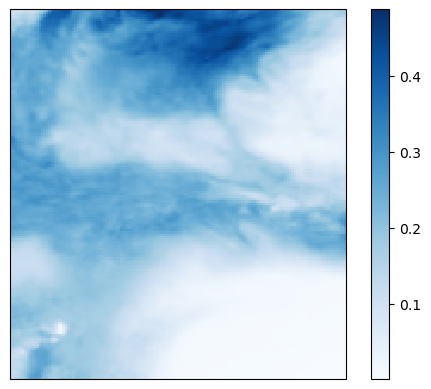

In [109]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

ax = plt.axes(projection = ccrs.PlateCarree())

mesh = ax.pcolormesh(np.arange(19.25,54.5,0.25),np.arange(-13.75,25,0.25)[::-1], np.mean(np.squeeze(sample[0]['lo_res_inputs'])[:,:,:5],axis=-1), cmap='Blues')
plt.colorbar(mesh)

# Sanity read-in and batch check for once data is created

In [28]:
import tensorflow as tf
from tfrecords_generator import _parse_batch

dataset = tf.data.TFRecordDataset('/network/group/aopp/predict/AWH026_NATH_GFSAIMOD/cGAN/tfrecords_gefs_v3/2018_36.3.tfrecords',compression_type='GZIP')




In [29]:

dataset = dataset.map(lambda x: _parse_batch(x, insize = (120,120,32), consize=(120,120,2), outsize=(120,120,1)))
test = dataset.repeat().batch(2)      
for inputs,outputs in test.take(1).as_numpy_iterator():

    print(inputs['lo_res_inputs'].shape)

    break